# Análisis de Clústering


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
from pyclustertend import hopkins, vat
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sys
import matplotlib.cm as cm

### Análisis de Agrupamiento de datos realizados


<small>

### Clustering vulnerabilidad económica

1. ESCOLARIDAD_HOMBRE
2. ESCOLARIDAD_MUJER
3. ESCOLARIDAD_VICTIMA
4. ESCOLARIDAD_AGRESOR

### Clustering de empleo o actividad económica

1. OCUPACION_HOMBRE
2. OCUPACION_MUJER
3. OCUPACION_VICTIMA
4. OCUPACION_AGRESOR
5. DEDICA_VICTIMA
6. DEDICA_AGRESOR

### Clustering de impacto social

1. TOTAL_DIVORCIOS
2. TOTAL_VIF

### Clustering por perfil demográfico afectado

1. EDAD_HOMBRE
2. EDAD_MUJER
3. EDAD_VICTIMA
4. EDAD_AGRESOR

### Clustering de actividad socioeconómica e impacto social

1. OCUPACION_VICTIMA
2. OCUPACION_AGRESOR
3. DEDICA_VICTIMA
4. DEDICA_AGRESOR
5. TOTAL_VIF
6. TOTAL_DIVORCIOS

</small>


### Cargar DataFrame


In [27]:
df = pd.read_csv("../CSV/FinalCSV/dataset_unificado_limpio.csv")

### Limpieza de Datos y aplicación de OneHotEncoder


In [28]:
# Copia para no afectar el original
df_temp = df.copy()

# Rellenar columnas numéricas con 0 
columnas_numericas = [
    'EDAD_HOMBRE', 'EDAD_MUJER', 'EDAD_VICTIMA', 'EDAD_AGRESOR',
    'TOTAL_DIVORCIOS', 'TOTAL_VIF',
    'ESCOLARIDAD_HOMBRE', 'ESCOLARIDAD_MUJER',
    'ESCOLARIDAD_VICTIMA', 'ESCOLARIDAD_AGRESOR',
    'OCUPACION_HOMBRE', 'OCUPACION_MUJER',
    'OCUPACION_VICTIMA', 'OCUPACION_AGRESOR',
    'DEDICA_VICTIMA', 'DEDICA_AGRESOR',
    'VIC_TRABAJA', 'AGR_TRABAJA',
    'INST_DENUNCIA'
]

df_temp[columnas_numericas] = df_temp[columnas_numericas].fillna(0)

# Variable categórica
columna_categorica = ['TIPO_MEDIDA_MAS_FREC']
df_temp[columna_categorica] = df_temp[columna_categorica].fillna('DESCONOCIDO')

# Preparar OneHotEncoder para la categórica y StandardScaler para las numéricas
preprocesador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columna_categorica)
    ]
)

# Aplicar el pipeline
pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesador)
])

df_clustering = pipeline.fit_transform(df_temp)

# Convertir el resultado a DataFrame con nombres de columnas
ohe_columns = pipeline.named_steps['preprocesamiento'].named_transformers_['cat'].get_feature_names_out(columna_categorica)
all_columns = columnas_numericas + list(ohe_columns)

# Crear DataFrame final para clustering
df_ready = pd.DataFrame(df_clustering, columns=all_columns)

# Mostrar un resumen
print(" DataFrame listo para clustering.")
print(df_ready.head())

print([col for col in df_ready.columns if col.startswith('TIPO_MEDIDA_MAS_FREC')])


 DataFrame listo para clustering.
   EDAD_HOMBRE  EDAD_MUJER  EDAD_VICTIMA  EDAD_AGRESOR  TOTAL_DIVORCIOS  \
0    -1.154841   -1.153545      0.371917      0.110481        -0.328989   
1     0.954714    1.052130      0.299760     -0.127011         1.600072   
2     0.959366    1.053796      0.660320      0.073382         2.559707   
3     0.901114    1.000934      0.706569      0.206505         8.301196   
4     0.855279    0.992447      0.704472     -0.056222         2.241461   

   TOTAL_VIF  ESCOLARIDAD_HOMBRE  ESCOLARIDAD_MUJER  ESCOLARIDAD_VICTIMA  \
0   4.294095           -0.619381          -0.625712             0.572607   
1   3.723605           -0.619381          -0.625712             0.849676   
2   3.880259           -0.619381          -0.625712             0.572607   
3   4.412214            0.075534           0.062871             2.696796   
4   4.166761            0.075534           0.062871             2.696796   

   ESCOLARIDAD_AGRESOR  ...  TIPO_MEDIDA_MAS_FREC_AFGIJ  \

### Agrupamiento por clusters predichos


In [29]:
# Clustering de vulnerabilidad educativa
grupo_educacion = [
    "ESCOLARIDAD_HOMBRE",
    "ESCOLARIDAD_MUJER",
    "ESCOLARIDAD_VICTIMA",
    "ESCOLARIDAD_AGRESOR"
]

# Clustering de empleo o actividad económica
grupo_empleo = [
    "OCUPACION_HOMBRE",
    "OCUPACION_MUJER",
    "OCUPACION_VICTIMA",
    "OCUPACION_AGRESOR",
    "DEDICA_VICTIMA",
    "DEDICA_AGRESOR"
]

# Clustering de impacto social
grupo_impacto = [
    "TOTAL_DIVORCIOS",
    "TOTAL_VIF"
]

# Clustering perfil demográfico
grupo_demografico = [
    "EDAD_HOMBRE",
    "EDAD_MUJER",
    "EDAD_VICTIMA",
    "EDAD_AGRESOR"
]

# Clustering socioeconómico + incidencia
grupo_socioeconomico = [
    "OCUPACION_VICTIMA",
    "OCUPACION_AGRESOR",
    "DEDICA_VICTIMA",
    "DEDICA_AGRESOR",
    "TOTAL_VIF",
    "TOTAL_DIVORCIOS"
]


### Creación de DataFrames por Grupo


In [30]:
df_educacion = df_ready[grupo_educacion].dropna().copy()
df_empleo = df_ready[grupo_empleo].dropna().copy()
df_impacto = df_ready[grupo_impacto].dropna().copy()
df_demografico = df_ready[grupo_demografico].dropna().copy()
df_socioeconomico = df_ready[grupo_socioeconomico].dropna().copy()

### Análisis de Hopkins


In [31]:
df_educacion_scaled = scale(df_educacion)
df_empleo_scaled = scale(df_empleo)
df_impacto_scaled = scale(df_impacto)
df_demografico_scaled = scale(df_demografico)
df_socioeconomico_scaled = scale(df_socioeconomico)

print(" Estadístico de Hopkins por grupo:")
print(f"Educación: {hopkins(df_educacion_scaled, df_educacion_scaled.shape[0]):.4f}")
print(f"Empleo: {hopkins(df_empleo_scaled, df_empleo_scaled.shape[0]):.4f}")
print(f"Impacto social: {hopkins(df_impacto_scaled, df_impacto_scaled.shape[0]):.4f}")
print(f"Perfil demográfico: {hopkins(df_demografico_scaled, df_demografico_scaled.shape[0]):.4f}")
print(f"Justicia: {hopkins(df_justicia_scaled, df_justicia_scaled.shape[0]):.4f}")
print(f"Sociodemográfico e incidencia: {hopkins(df_socioeconomico_scaled, df_socioeconomico_scaled.shape[0]):.4f}")


 Estadístico de Hopkins por grupo:
Educación: 0.0610
Empleo: 0.0111
Impacto social: 0.0384
Perfil demográfico: 0.1161
Justicia: 0.0255
Sociodemográfico e incidencia: 0.0372


### Análisis VAT



 VAT por grupo:


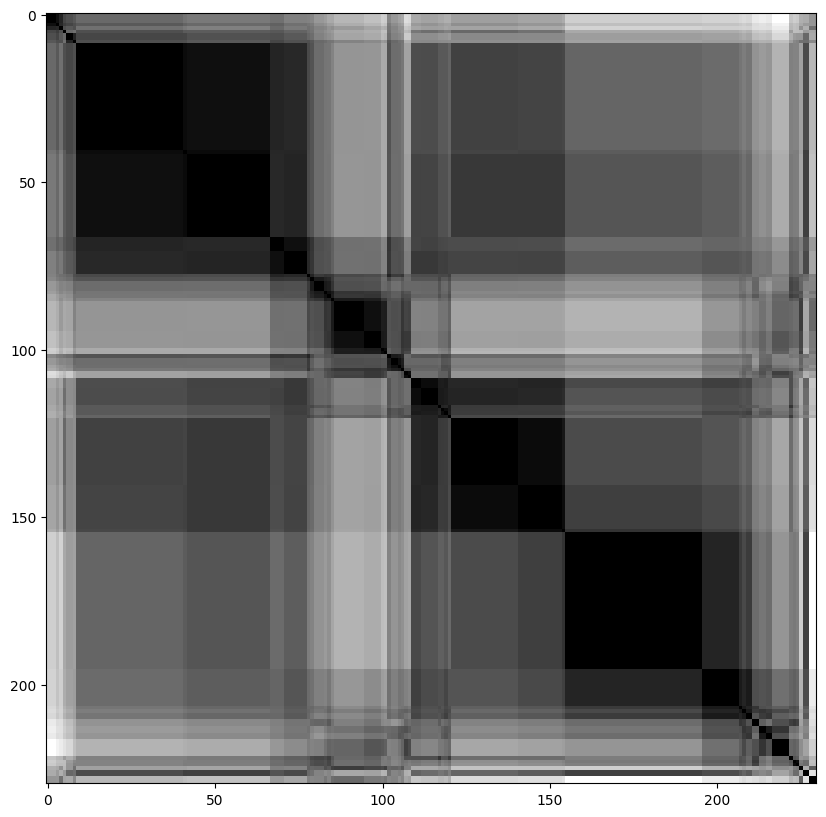

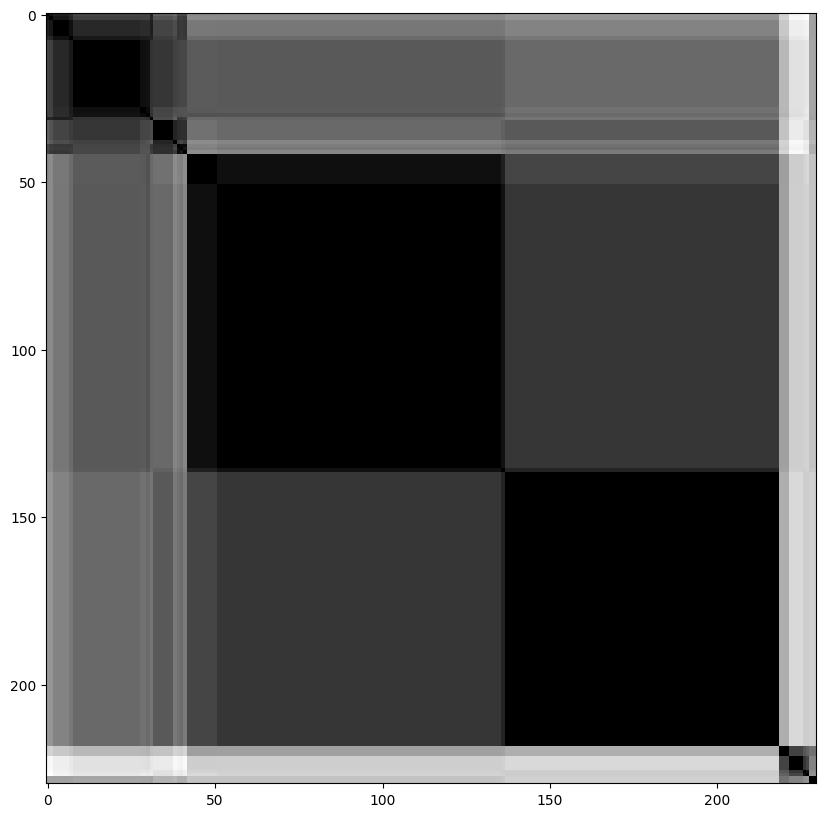

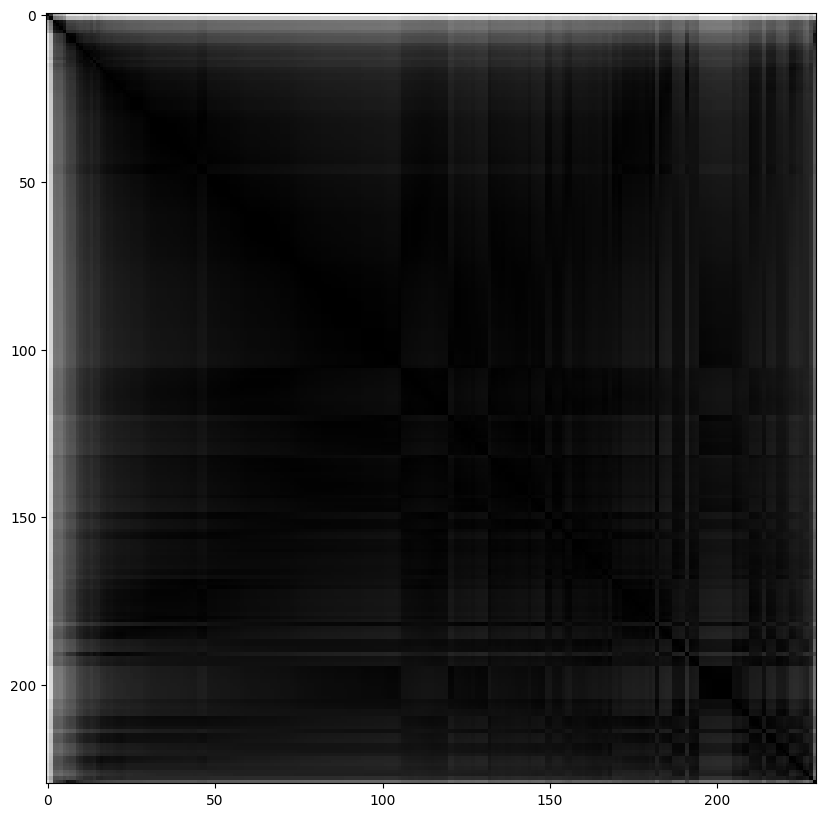

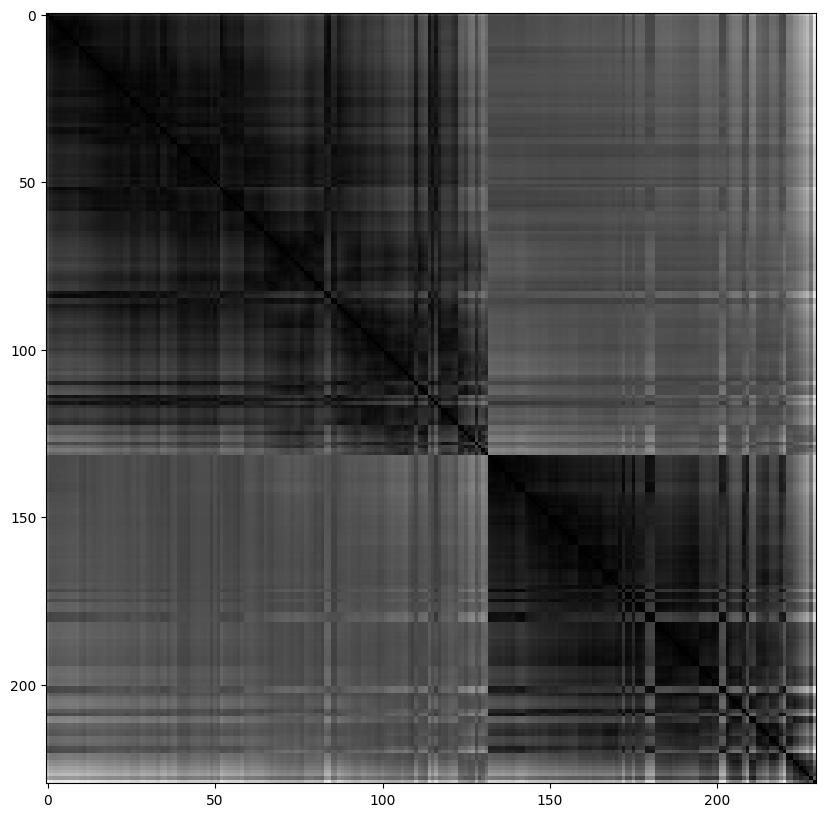

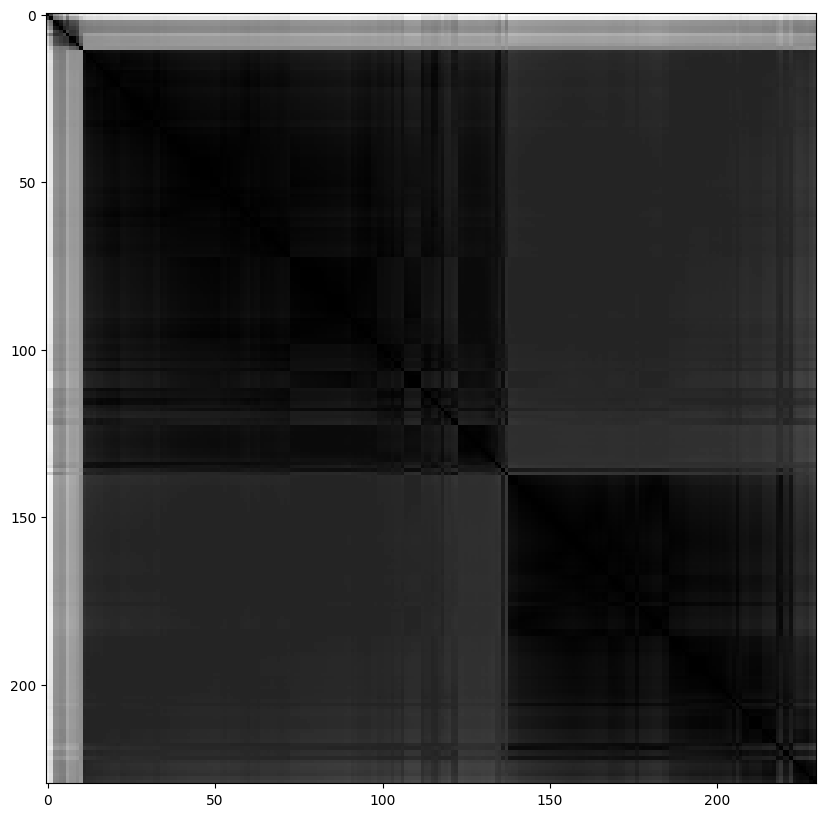

In [32]:
print("\n VAT por grupo:")
vat(df_educacion_scaled)
vat(df_empleo_scaled)
vat(df_impacto_scaled)
vat(df_demografico_scaled)
vat(df_socioeconomico_scaled)

### Número de clusters adecuados con gráficas de codo


In [33]:
def elbow_plot_for_group(features, group_name):
    # Extraer subconjunto
    df_group = df_ready[features].copy()

    # Convertir a numérico y llenar NaNs con la mediana
    for col in features:
        df_group[col] = pd.to_numeric(df_group[col], errors='coerce')
    df_group.fillna(df_group.median(numeric_only=True), inplace=True)

    # Normalizar
    X_scaled = scale(df_group)

    # Elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Gráfico
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title(f"Gráfico del Codo - {group_name}")
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Suma de cuadrados intra-cluster (WCSS)")
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

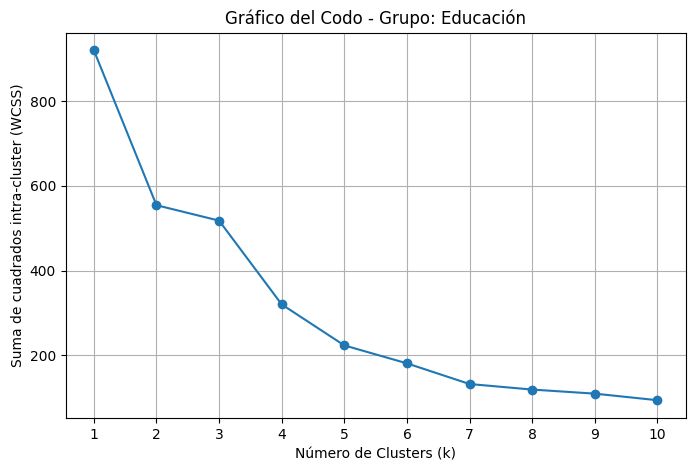

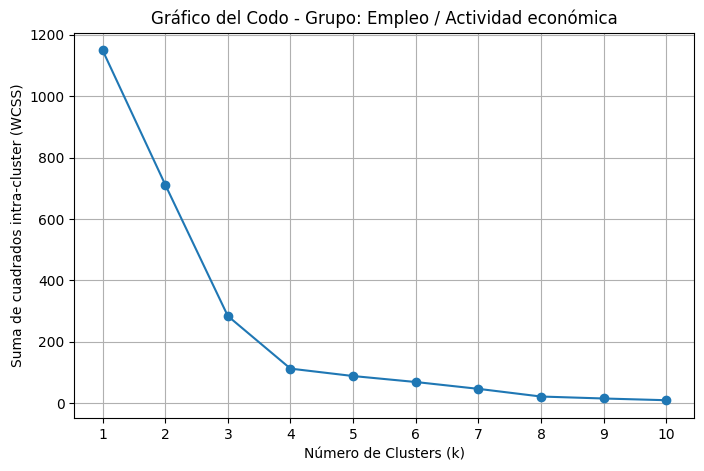

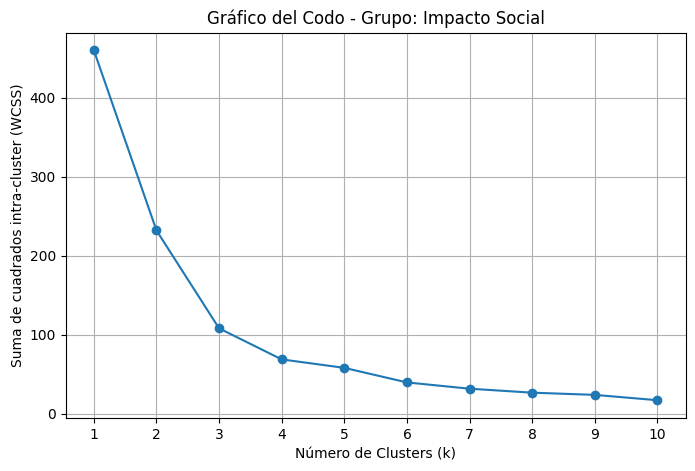

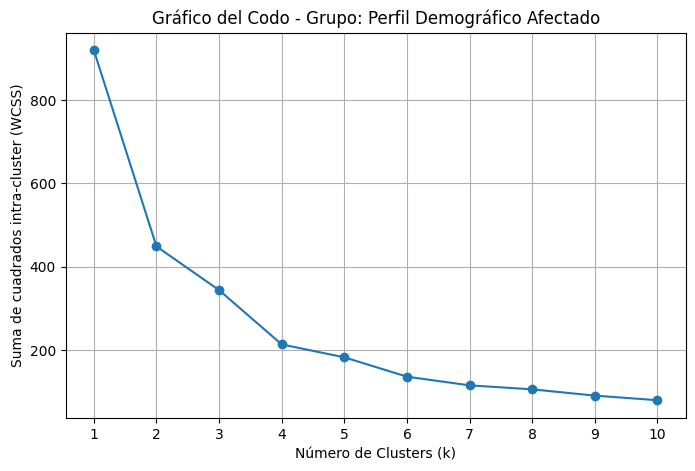

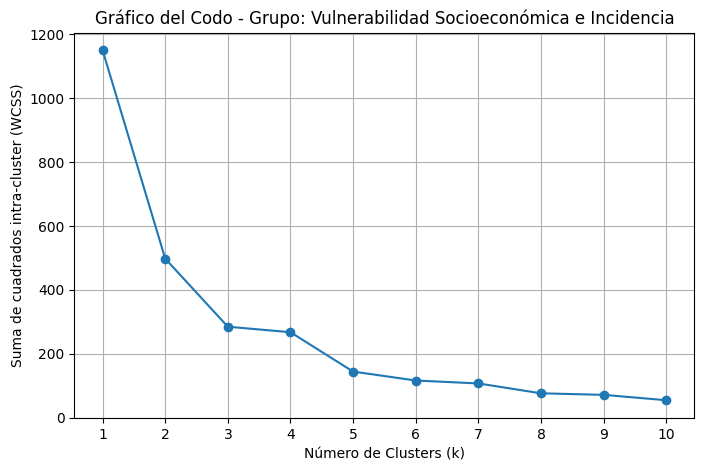

In [34]:
elbow_plot_for_group(grupo_educacion, "Grupo: Educación")
elbow_plot_for_group(grupo_empleo, "Grupo: Empleo / Actividad económica")
elbow_plot_for_group(grupo_impacto, "Grupo: Impacto Social")
elbow_plot_for_group(grupo_demografico, "Grupo: Perfil Demográfico Afectado")
elbow_plot_for_group(grupo_socioeconomico, "Grupo: Vulnerabilidad Socioeconómica e Incidencia")